## Importing the relevant libraries

In [1]:
!pip install wget tensorflow==2.10.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 40.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3110dafa37901277d06fdaa79f2fa1335c13836302d03e219ae18e6f81ebfce8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: keras
    Found existing installa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, punct, remove_digits, remove_links, remove_special_characters, remove_, removeStopWords, lower, email_address, non_ascii
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model, get_custom_objects
from tensorflow.keras.losses import SparseCategoricalCrossentropy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading the dataset

In [3]:
df = pd.read_csv('/content/Combined Data.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.sample(n=15000).reset_index(drop=True)
df.head()

,statement,status
0,lol i tried bye finally heard back from mental...,Suicidal
1,i doubt theyd care but at the same time i dont...,Depression
2,I do not want this to sound like a cry for hel...,Suicidal
3,I do not belong anywhere. I do not know why I ...,Suicidal
4,Can I continue to take weekend leave,Normal


## Data Exploration

In [4]:
df.shape

(15000, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  14899 non-null  object
 1   status     15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [6]:
df.describe()

,statement,status
count,14899,15000
unique,14748,7
top,what do you mean?,Normal
freq,7,4601


In [7]:
df.isna().sum()

,0
statement,101
status,0


In [8]:
df = df.dropna()
df.shape

(14899, 2)

## Exploratory Data Analysis (EDA)

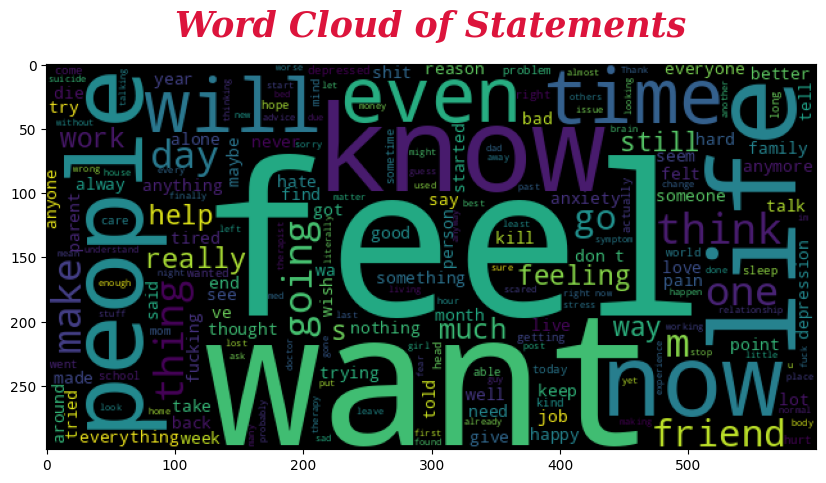

In [9]:
plt.figure(figsize=(11,5))
wc = WordCloud(width=600,height=300,random_state=101).generate(''.join(df.statement))
plt.title('Word Cloud of Statements',fontsize=25,fontweight='bold',color='crimson',fontfamily='serif',fontstyle='italic',pad=20)
plt.imshow(wc);

In [10]:
df['num_words'] = df.statement.apply(len)
df.num_words.describe()

,num_words
count,14899.000000
mean,578.079536
std,826.157078
min,2.000000
25%,78.000000
50%,320.000000
75%,758.000000
max,27588.000000


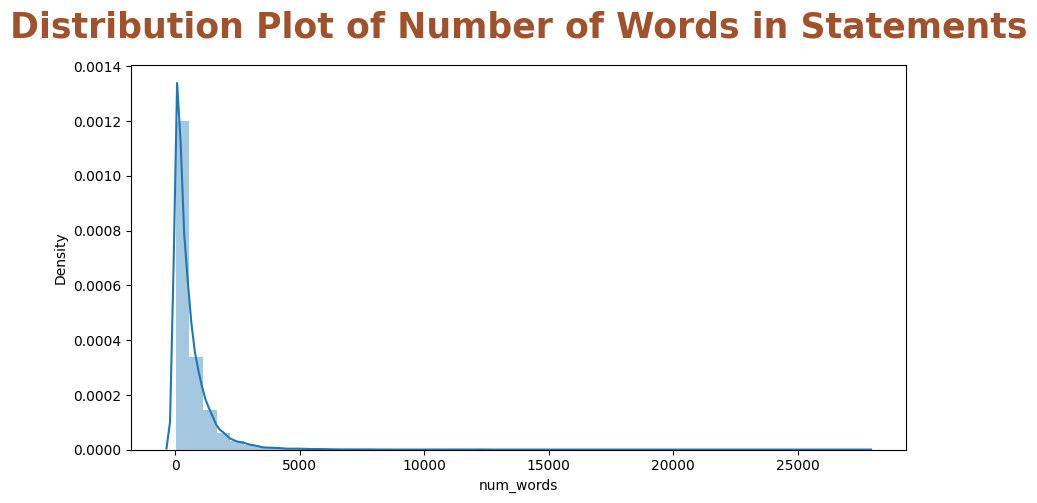

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(df['num_words'])
plt.title('Distribution Plot of Number of Words in Statements',pad=20,fontsize=25,color='sienna',fontweight='bold')
plt.show();

In [12]:
max_len = 85

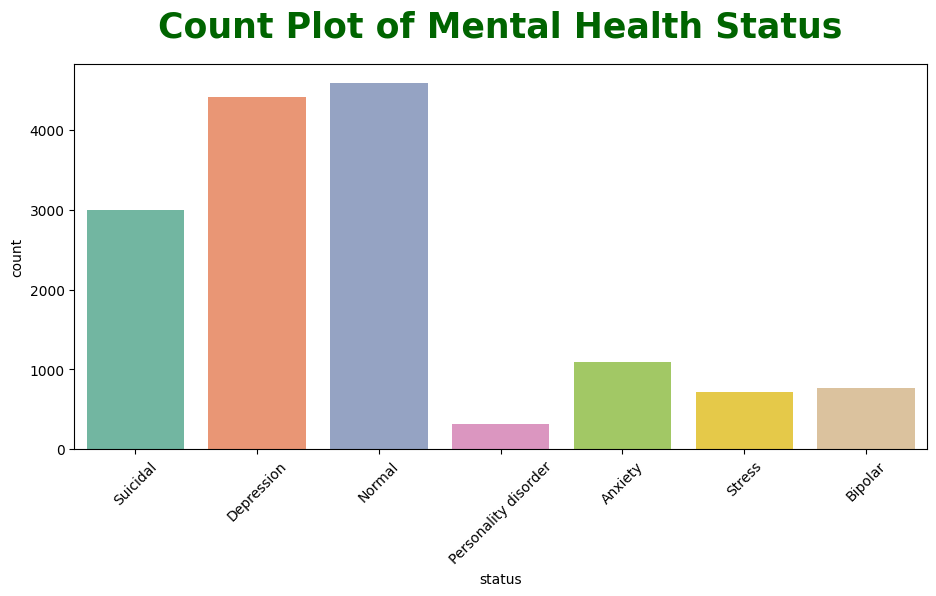

In [13]:
plt.figure(figsize=(11,5))
sns.countplot(x='status',data=df,palette='Set2')
plt.xticks(rotation=45)
plt.title('Count Plot of Mental Health Status',pad=20,fontsize=25,color='darkgreen',fontweight='bold')
plt.show();

It's clearly evident that the target label is highly imbalanced.

## Preprocessing the text data

In [14]:
def preprocess_text(data,col):
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    return data

In [15]:
preprocessed_df = preprocess_text(df,'statement')
preprocessed_df.head()

,statement,status,num_words
0,ol tried bye finally heard back mental health ...,Suicidal,198
1,doubt theyd care time dont wan na die alone pe...,Depression,495
2,want sound cry help struggling since years ol...,Suicidal,894
3,belong anywhere know born wish everyone family...,Suicidal,645
4,continue take weekend leave,Normal,36


In [16]:
preprocessed_df['num_words'] = preprocessed_df.statement.apply(len)
preprocessed_df.num_words.describe()

,num_words
count,14899.000000
mean,331.783811
std,470.386054
min,0.000000
25%,48.000000
50%,185.000000
75%,435.000000
max,14359.000000


## Splitting the processed dataset into train and test sets

In [17]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,shuffle=True,random_state=101,stratify=preprocessed_df['status'])

In [18]:
train_df.shape, test_df.shape

((10429, 3), (4470, 3))

## Encoding the target label

In [19]:
encoder = LabelEncoder()
train_df.status = encoder.fit_transform(train_df.status)
test_df.status = encoder.transform(test_df.status)

## Loading the pretrained Distilbert Tokenizer and model from Hugging Face

In [20]:
model_name = "AnuradhaPoddar/distilbert_mental_health_classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
distilbert_model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Text Tokenization

In [21]:
X_train = tokenizer(text=train_df['statement'].tolist(),
                    max_length=max_len,
                    padding=True,
                    truncation=True,
                    add_special_tokens=True,
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    return_tensors='tf',
                    verbose=1
                   )

X_test = tokenizer(text=test_df['statement'].tolist(),
                    max_length=max_len,
                    padding=True,
                    truncation=True,
                    add_special_tokens=True,
                    return_token_type_ids=False,
                    return_attention_mask=True,
                    return_tensors='tf',
                    verbose=1
                   )

## Defining fine-tuned DistilBERT model architecture

In [22]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [23]:
embeddings = distilbert_model(input_ids=input_ids,attention_mask=attention_mask)[0] # 0 -> final hidden state, 1 -> final pooling output
output = Flatten()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=64,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=32,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.1)(output)
output = Dense(units=7,activation='softmax')(output)
model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 85)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66957317   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 5),                                                 
                                 hidden_states=None                                           

## Visualizing the model architecture

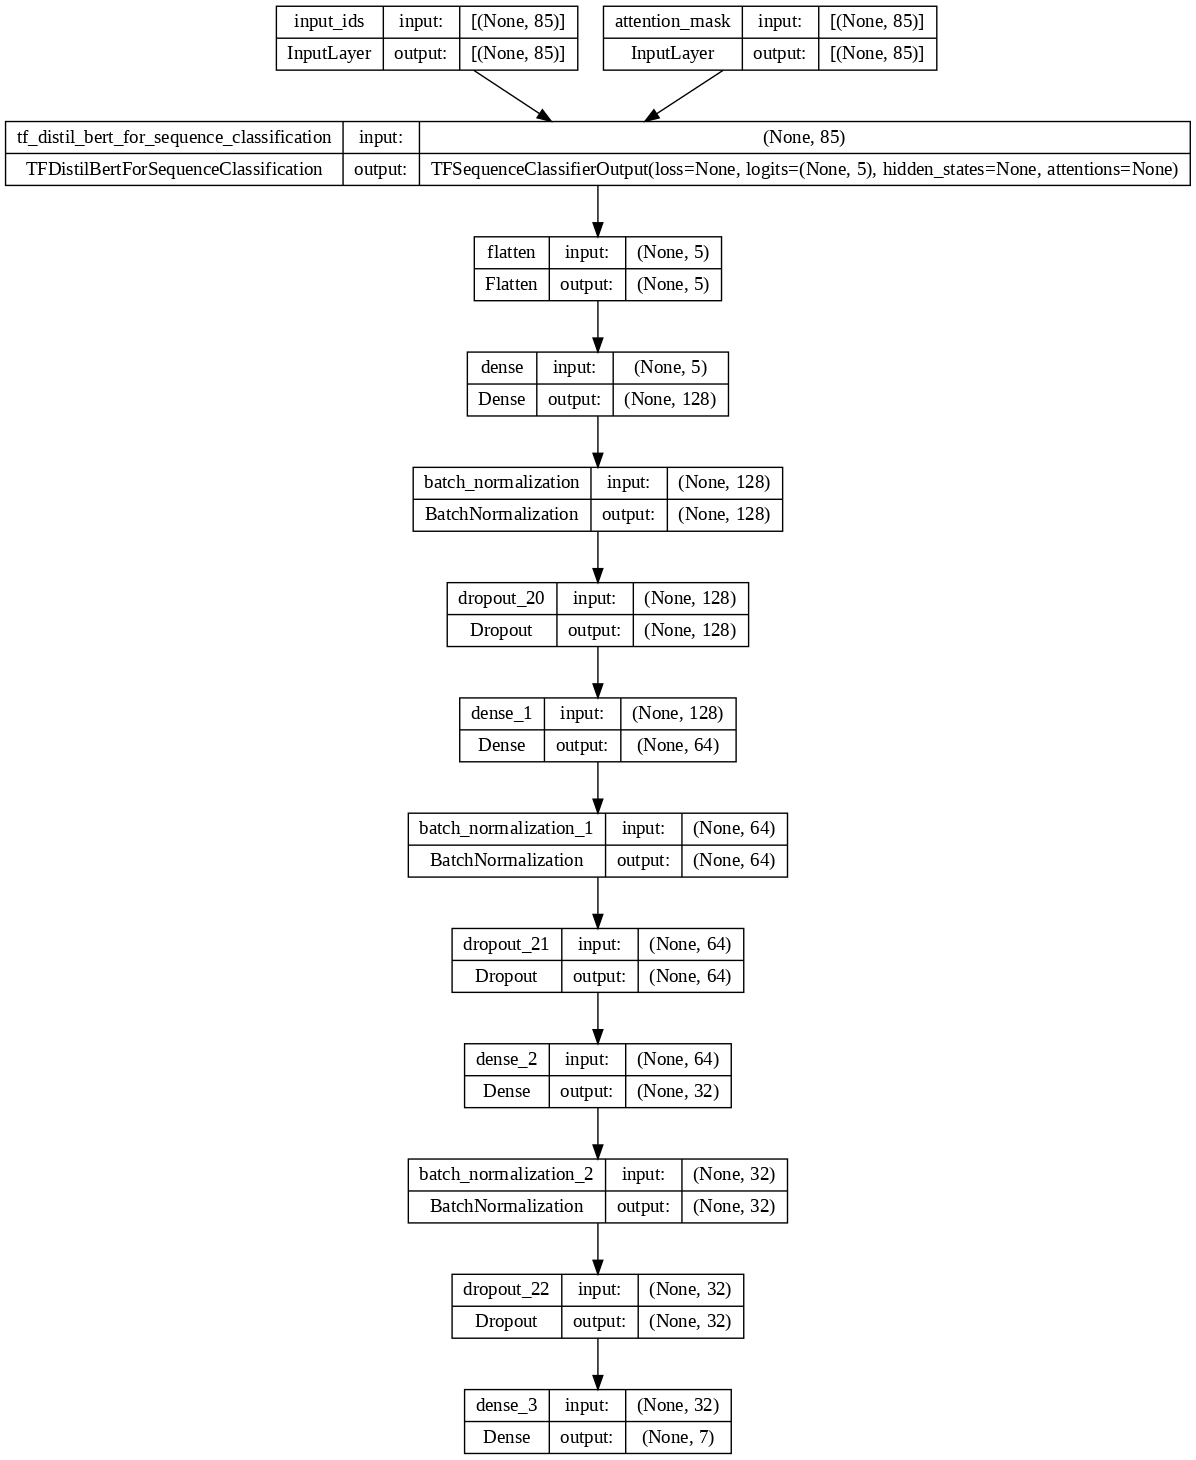

In [24]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100,rankdir='TB')

In [25]:
adam = AdamW(learning_rate=5e-5, epsilon=1e-8, weight_decay=1e-2, clipnorm=1.0)
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer=adam, metrics=['sparse_categorical_accuracy'])

In [26]:
def cosine_annealing(epoch, lr):
    """Cosine annealing learning rate scheduler with warm restarts.

    # Arguments
        epoch: int. epoch number.
        lr: float. previous learning rate.

    # Returns
        lr: float. updated learning rate.
    """
    max_lr = 5e-5
    min_lr = 1e-6
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / 25))

In [27]:
# Determining balanced class weights for all classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df.status),
    y=train_df.status
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.944983215218202,
 1: 2.7847797062750335,
 2: 0.48246669133974834,
 3: 0.4628322904184973,
 4: 6.772077922077922,
 5: 2.9502121640735504,
 6: 0.7108097055616139}

## Training the fine-tuned DistilBERT model

In [ ]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy',mode='max',patience=10,restore_best_weights=True,verbose=1)
mc = ModelCheckpoint(filepath='mental_health_status_classifier.keras',
                    monitor='val_sparse_categorical_accuracy',
                    mode='max',
                    save_best_only=True,
                    save_freq='epoch',
                    verbose=1)
lr = LearningRateScheduler(schedule=cosine_annealing,verbose=1)
tb = TensorBoard(log_dir='logs',histogram_freq=1,write_graph=True,update_freq='epoch')

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=train_df.status,
              epochs=25,
              batch_size=64,
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.status),
              callbacks=[es,lr,mc,tb],
              class_weight=class_weights_dict
             )


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/25
163/163 [==============================] - ETA: 0s - loss: 2.3076 - sparse_categorical_accuracy: 0.1761
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.12483, saving model to mental_health_status_classifier.keras
163/163 [==============================] - 1599s 10s/step - loss: 2.3076 - sparse_categorical_accuracy: 0.1761 - val_loss: 1.9950 - val_sparse_categorical_accuracy: 0.1248 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.9806810182204715e-05.
Epoch 2/25
163/163 [==============================] - ETA: 0s - loss: 2.0787 - sparse_categorical_accuracy: 0.2553
Epoch 2: val_sparse_categorical_accuracy improved from 0.12483 to 0.49575, saving model to mental_health_status_classifier.keras
163/163 [==============================] - 1576s 10s/step - loss: 2.0787 - sparse_categorical_accuracy: 0.2553 - val_loss: 1.4011 - val_sparse_categorical_accuracy: 0.4957 - lr: 4.9

## Visualizing model performance

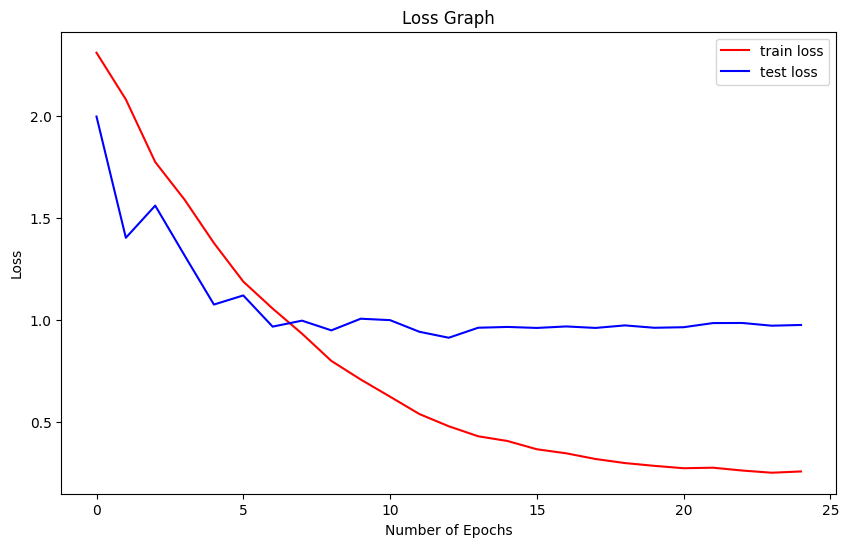

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

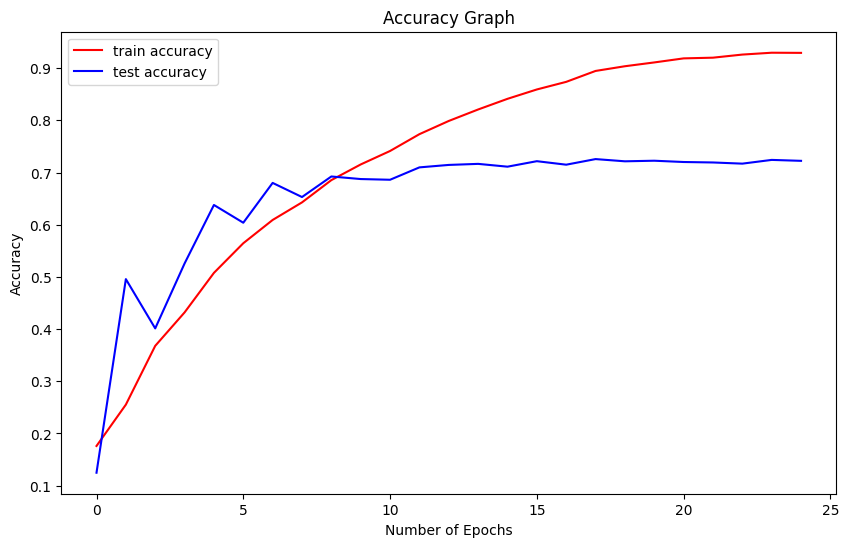

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(r.history['sparse_categorical_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_sparse_categorical_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Model Evaluation

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'],'attention_mask': X_test['attention_mask']},test_df.status)
print("Test Sparse Categorical Crossentropy Loss:", round(loss,2))
print("Test Sparse Categorical Accuracy:", round(acc*100,2))

140/140 [==============================] - 170s 1s/step - loss: 0.9739 - sparse_categorical_accuracy: 0.7224
Test Sparse Categorical Crossentropy Loss: 0.97
Test Sparse Categorical Accuracy: 72.24


## Saving the pretrained Tokenizer

In [ ]:
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## Loading the saved model

In [28]:
# Register the custom object
get_custom_objects()["TFDistilBertForSequenceClassification"] = distilbert_model

In [29]:
loaded_model = load_model('/content/mental_health_status_classifier.keras')
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 85)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66957317   ['input_ids[0][0]',              
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'attention_mask[0][0]']         
 rSequenceClassification)       logits=(None, 5),                                                 
                                 hidden_states=None                                           

## Making predictions on test data

Confusion Matrix:
[[ 270    9   25    9    5    7    4]
 [   5  182   30    6    2    1    4]
 [  27   40  905   46   14   17  274]
 [  18    2   20 1287    2   20   30]
 [   2    8   22    6   48    7    1]
 [  15    5   26   18    5  136   12]
 [   2    2  215   49    2   14  614]]
--------------------------------------------------------------------------------


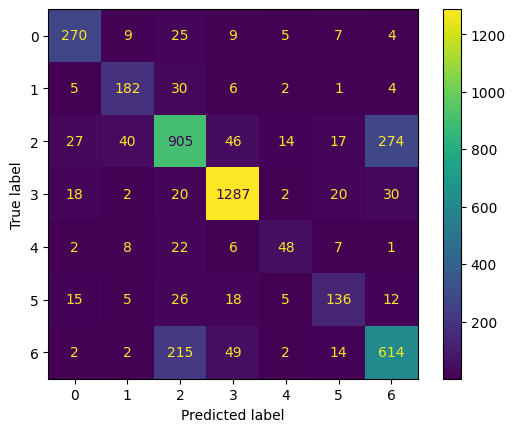

--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       329
           1       0.73      0.79      0.76       230
           2       0.73      0.68      0.71      1323
           3       0.91      0.93      0.92      1379
           4       0.62      0.51      0.56        94
           5       0.67      0.63      0.65       217
           6       0.65      0.68      0.67       898

    accuracy                           0.77      4470
   macro avg       0.73      0.72      0.72      4470
weighted avg       0.77      0.77      0.77      4470

--------------------------------------------------------------------------------


In [30]:
test_predictions = loaded_model.predict({'input_ids': X_test['input_ids'],'attention_mask': X_test['attention_mask']},verbose=0)
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.status,test_predictions))
print("--"*40)
ConfusionMatrixDisplay.from_predictions(test_df.status,test_predictions)
plt.show()
print("--"*40)
print("Classification Report:")
print(classification_report(test_df.status,test_predictions))
print("--"*40)

The fine-tuned DistilBERT transformer model has achieved a decent accuracy of about 77% on the test set.

## Model Inference

In [31]:
encoded_labels_dict = dict()

for idx, label in enumerate(encoder.classes_):
  encoded_labels_dict[idx] = label

encoded_labels_dict

{0: 'Anxiety',
 1: 'Bipolar',
 2: 'Depression',
 3: 'Normal',
 4: 'Personality disorder',
 5: 'Stress',
 6: 'Suicidal'}

In [40]:
texts = [
    "Everything's off; step back, dear, and let doubt take the lead. Remain in a state of constant restlessness.",
    "I'm not sure how I'm going to handle this. I'm so overwhelmed by the stress and anxiety. I'm not sure what to do.",
    "I've been feeling deeply depressed lately. I try to express my emotions instead of bottling them up, but I still don’t feel better and often feel sad. While I do have happy moments, there's this persistent sense of sadness that overshadows everything. Overall, I feel extremely down.",
    "I took propranolol for anxiety and stress but stopped after three weeks due to side effects. Since gradually reducing the dosage and stopping, I've been experiencing excessive sweating in my private area, especially around the sit area. Is this abnormal sweating related to beta blockers, and has anyone else experienced something similar?",
    "I have been feeling increasingly overwhelmed lately due to various personal and professional demands. This has led to persistent feelings of stress and occasional difficulty focusing or maintaining a positive outlook. Although I am managing my daily responsibilities, the constant pressure has started to impact my mental well-being. I recognize the importance of addressing this and am open to exploring strategies, such as mindfulness, physical activity, or professional support, to improve my mental health and regain balance.",
    "I've been doing great! How about you?",
    "He said that he is going to die within one week due to life pressures.",
    "I go through intense mood swings—one moment, I feel unstoppable and full of energy, but then I quickly spiral into deep sadness and exhaustion. It's like living on a roller coaster, and it’s hard to predict what’s coming next. Coping with these changes is tough, but I’m trying to figure out my patterns and find ways to manage them.",
    "I feel balanced and content in my daily life. I manage stress effectively and approach challenges with a positive mindset. My emotions are stable, and I maintain healthy relationships with those around me. I can focus on tasks, enjoy activities, and adapt well to changes or unexpected events.",
    "Why might Seroquel sometimes lead to hallucinations even though it's intended to suppress them? I recently increased my dose and have started experiencing mild auditory and visual hallucinations. I don't have schizophrenia but take 300mg of Seroquel and 200mg of Lamotrigine for bipolar II. The side effects aren’t severe—mostly congested sinuses and occasional dizziness—and it generally works well for its purpose. Has anyone else experienced this?",
    "I initially felt I had done well, but I was deeply depressed. That weekend, which happened to be my birthday, turned miserable because of him. He called me a brat for thinking my birthday was special, gave me the silent treatment, got drunk, and told me I was worthless and contributed nothing to him. I received neither a gift nor any affection.",
    "I’m a burden to everyone, and it feels like nothing will ever get better. Maybe it’s better if I wasn’t here.",
    "I only own one set of clothes and can't imagine visiting a clothing store. I prefer shopping online, but sizes often don't fit. I don't need many clothes since I rarely go out. I even cut my own hair instead of going to the barbershop. Although there's a supermarket nearby, I rely on online delivery for essentials. I used to visit supermarkets frequently when I was younger, but now, at 28 and still unemployed, I'm worried the owner might recognize me."
]

# Tokenize the texts
encoded_inputs = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='tf'
    )

# Extract input ids and attention masks
input_ids = encoded_inputs["input_ids"]
attention_mask = encoded_inputs["attention_mask"]

# Make predictions
predictions = loaded_model.predict({"input_ids": input_ids, "attention_mask": attention_mask},verbose=0)
predictions = np.argmax(predictions,axis=1)
predictions = predictions.tolist()
predictions = [encoded_labels_dict[pred] for pred in predictions]

for idx, pred in enumerate(predictions):
  print(f"Text: {texts[idx]}\nPredicted Category: {pred}\n")

Text: Everything's off; step back, dear, and let doubt take the lead. Remain in a state of constant restlessness.
Predicted Category: Anxiety

Text: I'm not sure how I'm going to handle this. I'm so overwhelmed by the stress and anxiety. I'm not sure what to do.
Predicted Category: Stress

Text: I've been feeling deeply depressed lately. I try to express my emotions instead of bottling them up, but I still don’t feel better and often feel sad. While I do have happy moments, there's this persistent sense of sadness that overshadows everything. Overall, I feel extremely down.
Predicted Category: Depression

Text: I took propranolol for anxiety and stress but stopped after three weeks due to side effects. Since gradually reducing the dosage and stopping, I've been experiencing excessive sweating in my private area, especially around the sit area. Is this abnormal sweating related to beta blockers, and has anyone else experienced something similar?
Predicted Category: Anxiety

Text: I have